# inspect area

In [1]:
!pip -q install earthaccess

In [5]:
import geopandas as gpd
import create_dataset
import numpy as np

In [3]:
shapefile_folder = 'data/shapefiles/'

geojson = 'iceland_trollaskagi_peninsula.geojson'  
geojson = 'grandmesa.geojson'

fn = f'{shapefile_folder}{geojson}'

bbox_gdf = gpd.read_file(fn)
bbox_gdf.attrs = {'filename':fn}

In [ ]:
resolution = 30

In [ ]:
year = 2020

In [ ]:
time_reference_scenes = slice(f'{year}-01-01',f'{year}-03-31') # northern hemisphere winter winter
time_reference_scenes = slice(f'{year}-06-01',f'{year}-07-31') 

time_target_scene = f'{year}-06-27' # try and support time_wet_scene_asc and time_wet_scene_desc
time_target_scene = f'{year}-04-27' # try and support time_wet_scene_asc and time_wet_scene_desc

In [ ]:
reference_scenes_aggregation_technique = 'median' # mean / median / max

In [1]:
ts_ds = create_dataset.get_s1_rtc(bbox_gdf)

NameError: name 'create_dataset' is not defined

In [ ]:
%%time
dataset = create_dataset.create_dataset(bbox_gdf, 
                                        year, 
                                        time_reference_scenes, 
                                        time_target_scene, 
                                        reference_scenes_aggregation_technique, 
                                        resolution)

In [2]:
import pandas as pd
import glob
import create_dataset
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import os
import matplotlib.colors as colors

In [3]:
dataframes_folder = 'data/dataframes/'
fn = 'grandmesa_2023_tar_2023-06-01_ref_2023-06-01_2023-09-01_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2023_tar_2023-06-01_ref_2023-06-01_2023-09-01_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2015_tar_2015-06-27_ref_2015-01-01_2015-03-01_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2015_tar_2015-06-27_ref_2015-01-01_2015-12-31_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2015_tar_2015-06-27_ref_2015-01-01_2015-12-31_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2015_tar_2015-06-27_ref_2015-01-01_2015-03-31_median_100.parquet'
#fn = 'grandmesa_2020_tar_2020-04-27_ref_2020-06-01_2020-07-31_median_100.parquet'
fn = 'grandmesa_2020_tar_2020-04-27_ref_2020-06-01_2020-07-31_median_30.parquet'



dataframe = pd.read_parquet(f'{dataframes_folder}{fn}')

all_files = glob.glob(os.path.join(dataframes_folder, "grandmesa*median_100.parquet"))
dataframe = pd.concat((pd.read_parquet(f) for f in all_files), ignore_index=True)

In [4]:
all_files

['data/dataframes/grandmesa_2023_tar_2023-04-27_ref_2023-06-01_2023-07-31_median_100.parquet',
 'data/dataframes/grandmesa_2017_tar_2017-04-27_ref_2017-06-01_2017-07-31_median_100.parquet',
 'data/dataframes/grandmesa_2020_tar_2020-04-27_ref_2020-06-01_2020-07-31_median_100.parquet',
 'data/dataframes/grandmesa_2018_tar_2018-04-27_ref_2018-06-01_2018-07-31_median_100.parquet',
 'data/dataframes/grandmesa_2022_tar_2022-04-27_ref_2022-06-01_2022-07-31_median_100.parquet',
 'data/dataframes/grandmesa_2016_tar_2016-04-27_ref_2016-06-01_2016-07-31_median_100.parquet',
 'data/dataframes/grandmesa_2019_tar_2019-04-27_ref_2019-06-01_2019-07-31_median_100.parquet',
 'data/dataframes/grandmesa_2015_tar_2015-04-27_ref_2015-06-01_2015-07-31_median_100.parquet',
 'data/dataframes/grandmesa_2021_tar_2021-04-27_ref_2021-06-01_2021-07-31_median_100.parquet',
 'data/dataframes/grandmesa_2020_tar_2020-04-27_ref_2020-01-01_2020-03-31_median_100.parquet']

In [5]:
dataframe = dataframe[dataframe['local_incidence_angle']<101]

In [9]:
dataframe['dawn_or_dusk'] = dataframe['sat:orbit_state'].apply(lambda x: 'dawn' if x == 'descending' else 'dusk')

In [10]:
dataframe

,y,x,sat:relative_orbit,band,time,sat:orbit_state,ratio_images,spatial_ref,local_incidence_angle,esa_worldcover,forest_cover_fraction,snow_class,modis_ndsi,dawn_or_dusk
0,4332050.0,758950.0,49,vv,2023-04-25 01:11:02.877215,ascending,-1.324939,0,51.998942,10.0,71.0,6.0,31.0,dusk
1,4332050.0,758950.0,49,vh,2023-04-25 01:11:02.877215,ascending,-0.743186,0,51.998942,10.0,71.0,6.0,31.0,dusk
2,4332050.0,758950.0,129,vv,2023-04-18 13:18:39.862645,descending,-1.277365,0,48.931213,10.0,71.0,6.0,31.0,dawn
3,4332050.0,758950.0,129,vh,2023-04-18 13:18:39.862645,descending,-0.818974,0,48.931213,10.0,71.0,6.0,31.0,dawn
4,4332050.0,759050.0,49,vv,2023-04-25 01:11:02.877215,ascending,-1.575019,0,44.791094,10.0,86.0,6.0,31.0,dusk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424916,4306750.0,733950.0,129,vh,2020-04-21 13:18:25.260788,descending,0.335165,0,50.734064,60.0,0.0,4.0,0.0,dawn
2424917,4306750.0,734050.0,49,vv,2020-04-22 01:09:50.954696,ascending,0.527761,0,51.589747,60.0,0.0,4.0,0.0,dusk
2424918,4306750.0,734050.0,49,vh,2020-04-22 01:09:50.954696,ascending,0.748983,0,51.589747,60.0,0.0,4.0,0.0,dusk
2424919,4306750.0,734050.0,129,vv,2020-04-21 13:18:25.260788,descending,-0.195031,0,46.789163,60.0,0.0,4.0,0.0,dawn


In [11]:
ndsi_thresh =  [30,70] # 40 #[40,60] #40 #[40,70]

In [12]:
dataframe = create_dataset.dataframe_ndsi_to_binary(dataframe,ndsi_thresh)

In [13]:
bins = [0,10,20,30,40,50,60,70,80,90,100]
labels = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']


# Create bins for the 'local_incidence_angle' column
dataframe['local_incidence_angle_bins'] = pd.cut(dataframe['local_incidence_angle'], bins=bins, labels=labels)

dataframe['forest_cover_fraction_bins'] = pd.cut(dataframe['forest_cover_fraction'], bins=bins, labels=labels)

/tmp/ipykernel_431/1174614055.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['local_incidence_angle_bins'] = pd.cut(dataframe['local_incidence_angle'], bins=bins, labels=labels)
/tmp/ipykernel_431/1174614055.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['forest_cover_fraction_bins'] = pd.cut(dataframe['forest_cover_fraction'], bins=bins, labels=labels)


In [14]:
#dataframe.corr(numeric_only=True)

In [15]:
#dataframe = create_dataset.dataframe_numbers_to_classes(dataframe)

In [16]:
parts = fn.split('_')
target_time = parts[parts.index('tar') + 1]

time_diff = (dataframe['time'] - pd.to_datetime(target_time)).abs()
mask = time_diff <= pd.Timedelta(days=10)

dataframe = dataframe[mask]

In [17]:
pal = {0:'peru',1:'dodgerblue'} 

In [18]:
def calculate_threshold_otsu(group):
    values = group['ratio_images'].values
    return threshold_otsu(values)


def calculate_threshold_logistic(group):
    X = group[['ratio_images']]
    y = group['modis_binary']
    
    if (len(np.unique(y)) == 2) & (y.value_counts().min()>50):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        model = LogisticRegression(class_weight='balanced')
        model.fit(X_train, y_train)
        difference_array = np.absolute(0.5-model.predict_proba(X)[:,1])
        index = difference_array.argmin()
        thresh = X.values[index][0]
    else:
        thresh = np.nan 
        
    return thresh 

def calculate_roc_auc_logistic(group):
    X = group[['ratio_images']]
    y = group['modis_binary']
    
    if (len(np.unique(y)) == 2) & (y.value_counts().min()>50):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        model = LogisticRegression(class_weight='balanced')
        model.fit(X_train, y_train)
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1],average='weighted') # add average
        
    else:
        auc = np.nan
    
    return auc


def calculate_accuracy_logistic(group):
    X = group[['ratio_images']]
    y = group['modis_binary']
    
    if (len(np.unique(y)) == 2) & (y.value_counts().min()>50):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        model = LogisticRegression(class_weight='balanced')
        model.fit(X_train, y_train)
        acc = model.score(X_test,y_test)
    else:
        acc = np.nan
    
    return acc

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    #d = data.pivot(index=args[1], columns=args[0], values=args[2])
    pivot_table = data.pivot_table(values='val', index='forest_cover_fraction_bins', columns='local_incidence_angle_bins')
    ax = sns.heatmap(pivot_table, cmap='viridis',annot=True, cbar_ax=cbar_ax, vmin=df_vmin, vmax=df_vmax, fmt='.2f', **kwargs)
    return ax

In [33]:
thresholds_otsu = dataframe.groupby(
    ['sat:orbit_state','band','local_incidence_angle_bins']).apply(calculate_threshold_otsu).reset_index().rename({0:'val'},axis='columns') 

In [34]:
thresholds_logistic = dataframe.groupby(
    ['sat:orbit_state','band','local_incidence_angle_bins']).apply(calculate_threshold_logistic).reset_index().rename({0:'val'},axis='columns')

In [35]:
roc_auc_logistic = dataframe.groupby(
    ['sat:orbit_state','band','local_incidence_angle_bins']).apply(calculate_roc_auc_logistic).reset_index().rename({0:'val'},axis='columns')

In [36]:
accuracy_logistic = dataframe.groupby(
    ['sat:orbit_state','band','local_incidence_angle_bins']).apply(calculate_accuracy_logistic).reset_index().rename({0:'val'},axis='columns')

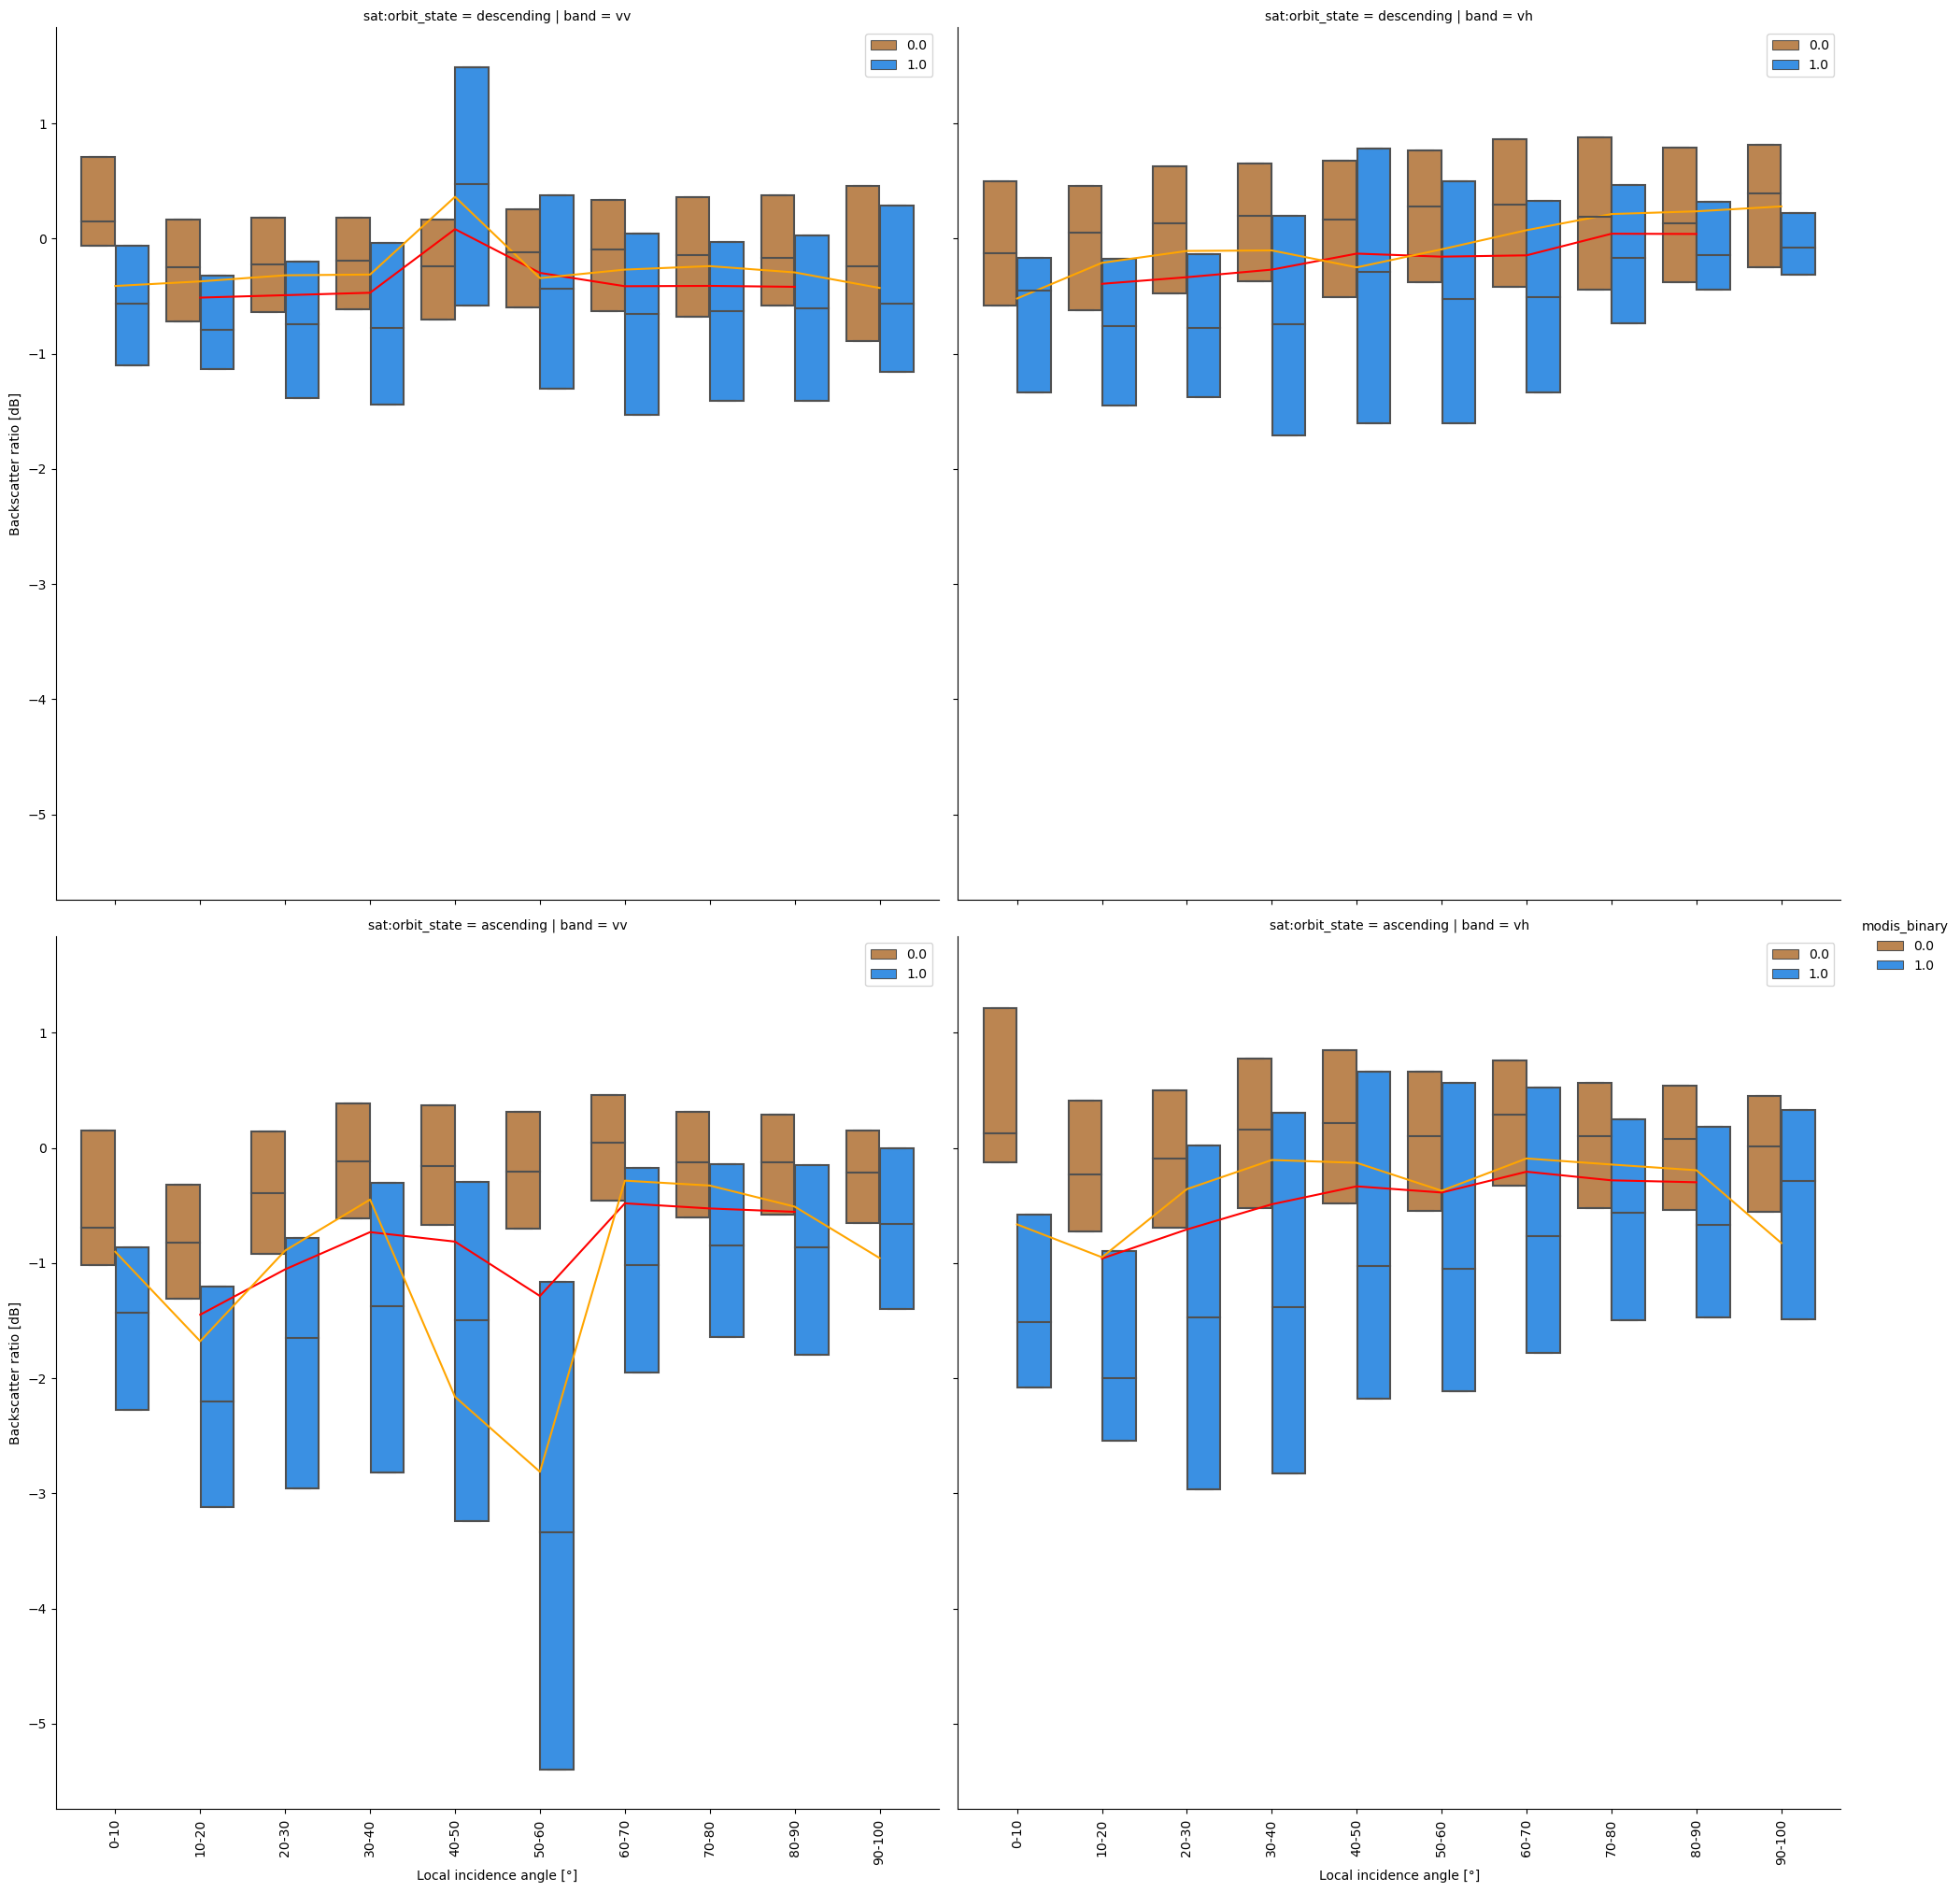

In [39]:
g = sns.catplot(x='local_incidence_angle_bins', y='ratio_images', hue="modis_binary", data=dataframe,
               row="sat:orbit_state", col='band', kind='box', showfliers=False, whis=0, palette=pal, height=10)

row_values = dataframe['sat:orbit_state'].unique()
col_values = dataframe['band'].unique()
row_indices = {value: i for i, value in enumerate(row_values)}
col_indices = {value: i for i, value in enumerate(col_values)}


for (row_value, col_value), _ in g.axes_dict.items():
        row_index = row_indices[row_value]
        col_index = col_indices[col_value]
        
        sns.lineplot(thresholds_logistic[(thresholds_logistic['sat:orbit_state'] == row_value) & (thresholds_logistic['band'] == col_value)],
                     x="local_incidence_angle_bins", y='val', color='red', ax=g.facet_axis(row_index, col_index))
        sns.lineplot(thresholds_otsu[(thresholds_otsu['sat:orbit_state'] == row_value) & (thresholds_otsu['band'] == col_value)],
                     x="local_incidence_angle_bins", y='val', color='orange', ax=g.facet_axis(row_index, col_index))
        

for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Backscatter ratio [dB]')
    ax.set_xlabel('Local incidence angle [\N{degree sign}]')

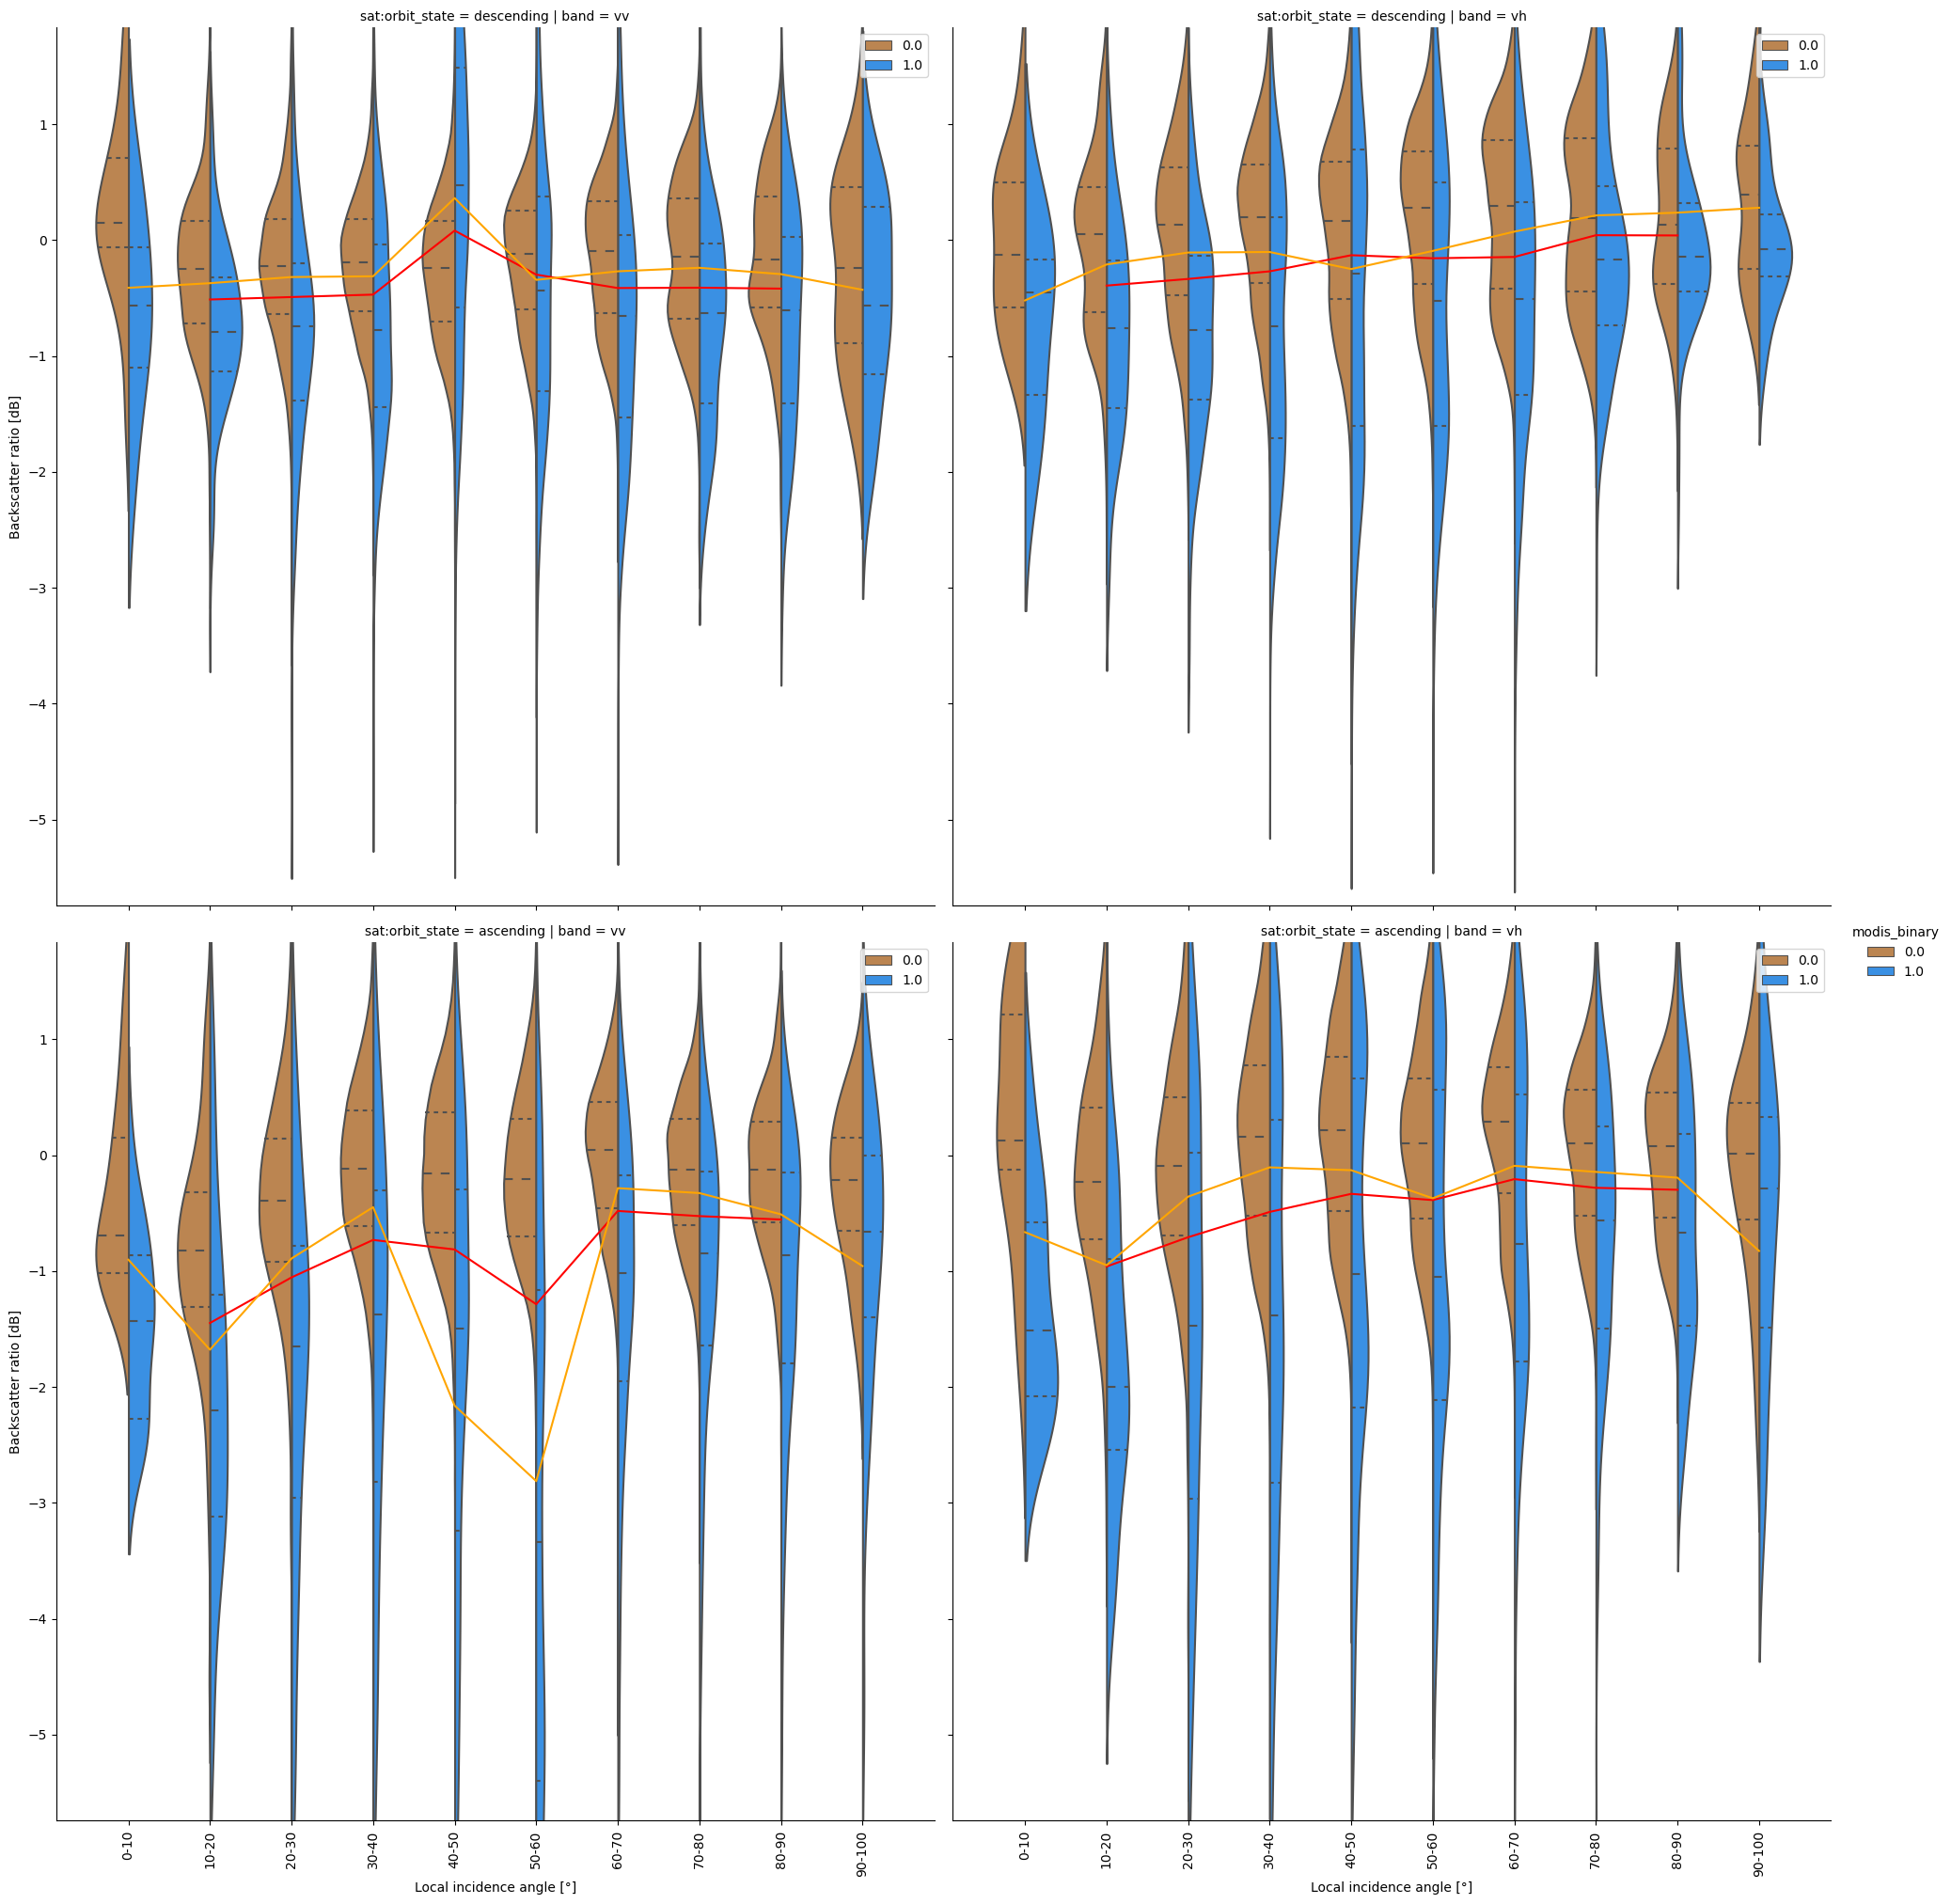

In [40]:
g = sns.catplot(x='local_incidence_angle_bins', y='ratio_images', hue="modis_binary", data=dataframe,
               row="sat:orbit_state", col='band', kind='violin',split=True,inner='quart', palette=pal, height=10)

row_values = dataframe['sat:orbit_state'].unique()
col_values = dataframe['band'].unique()
row_indices = {value: i for i, value in enumerate(row_values)}
col_indices = {value: i for i, value in enumerate(col_values)}
        
for (row_value, col_value), _ in g.axes_dict.items():
        row_index = row_indices[row_value]
        col_index = col_indices[col_value]
        
        sns.lineplot(thresholds_logistic[(thresholds_logistic['sat:orbit_state'] == row_value) & (thresholds_logistic['band'] == col_value)],
                     x="local_incidence_angle_bins", y='val', color='red', ax=g.facet_axis(row_index, col_index))
        sns.lineplot(thresholds_otsu[(thresholds_otsu['sat:orbit_state'] == row_value) & (thresholds_otsu['band'] == col_value)],
                     x="local_incidence_angle_bins", y='val', color='orange', ax=g.facet_axis(row_index, col_index))

for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Backscatter ratio [dB]')
    ax.set_xlabel('Local incidence angle [\N{degree sign}]')

In [108]:
thresholds_logistic = dataframe.groupby(
    ['sat:orbit_state','band','local_incidence_angle_bins','forest_cover_fraction_bins'],dropna=True
).apply(calculate_threshold_logistic).reset_index().rename({0:'val'},axis='columns') 

/srv/conda/envs/notebook/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


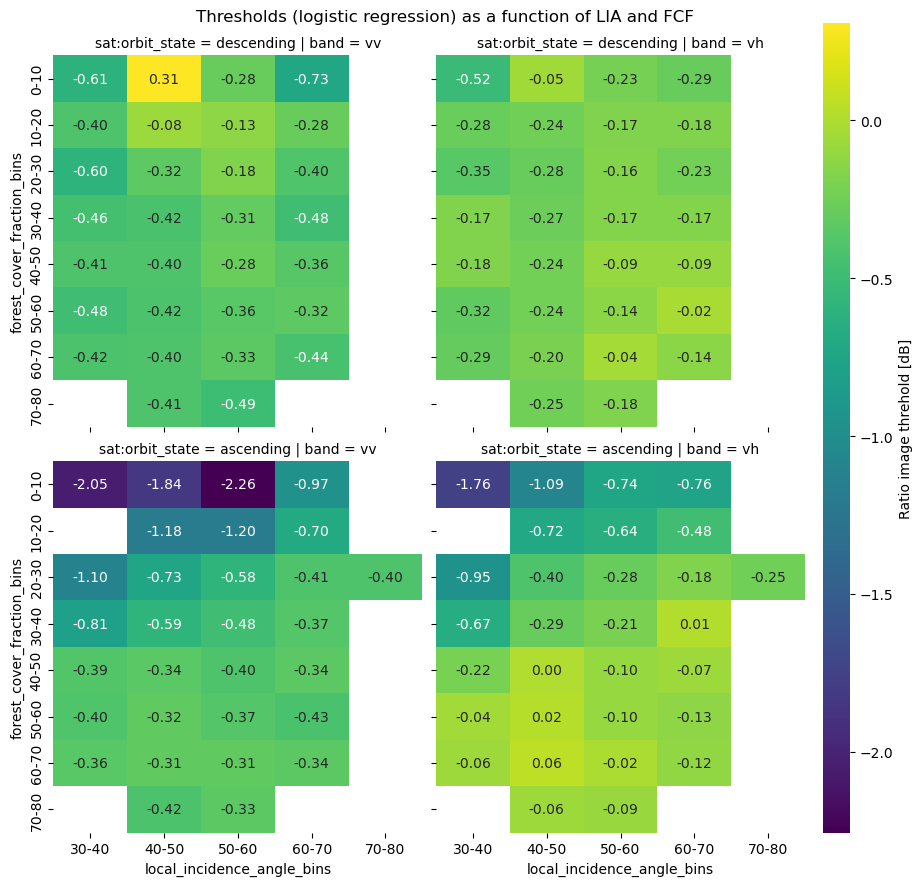

In [116]:
df = thresholds_logistic
df_vmin = df['val'].min()
df_vmax = df['val'].max()

g = sns.FacetGrid(df, row="sat:orbit_state", col="band", row_order= ['descending','ascending'], col_order=['vv','vh'], legend_out=True, height=4.5)
cbar_ax = g.fig.add_axes([.92, .065, .03, .9])
    
g.map_dataframe(draw_heatmap)
g.fig.suptitle('Thresholds (logistic regression) as a function of LIA and FCF')

cbar = g.axes.flat[0].collections[0].colorbar
cbar.set_label('Ratio image threhold [dB]')

g.tight_layout()
g.fig.subplots_adjust(right=0.9)

In [114]:
accuracy_logistic = dataframe.groupby(
    ['sat:orbit_state','band','local_incidence_angle_bins','forest_cover_fraction_bins'],dropna=True
).apply(calculate_accuracy_logistic).reset_index().rename({0:'val'},axis='columns') 

/srv/conda/envs/notebook/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


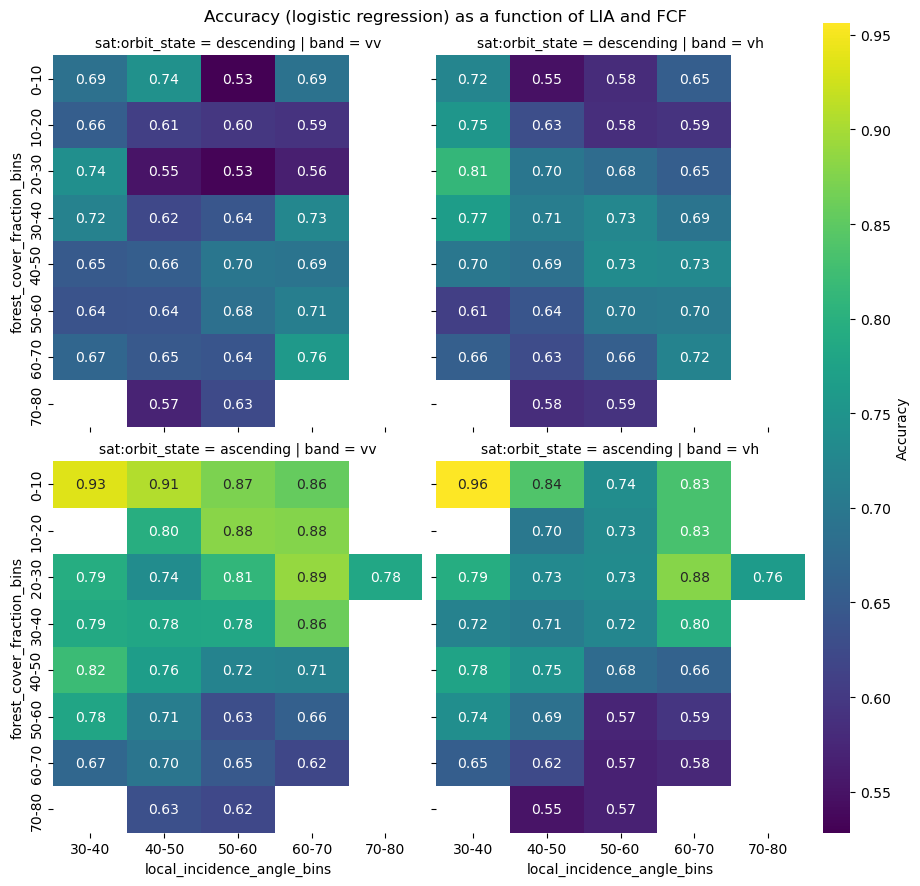

In [117]:
df = accuracy_logistic
df_vmin = df['val'].min()
df_vmax = df['val'].max()

g = sns.FacetGrid(df, row="sat:orbit_state", col="band", row_order= ['descending','ascending'], col_order=['vv','vh'], legend_out=True, height=4.5)
cbar_ax = g.fig.add_axes([.92, .065, .03, .9])
    
g.map_dataframe(draw_heatmap)
g.fig.suptitle('Accuracy (logistic regression) as a function of LIA and FCF')

cbar = g.axes.flat[0].collections[0].colorbar
cbar.set_label('Accuracy')

g.tight_layout()
g.fig.subplots_adjust(right=0.9)

In [120]:
roc_auc_logistic = dataframe.groupby(
    ['sat:orbit_state','band','local_incidence_angle_bins','forest_cover_fraction_bins'],dropna=True
).apply(calculate_roc_auc_logistic).reset_index().rename({0:'val'},axis='columns') 

/srv/conda/envs/notebook/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


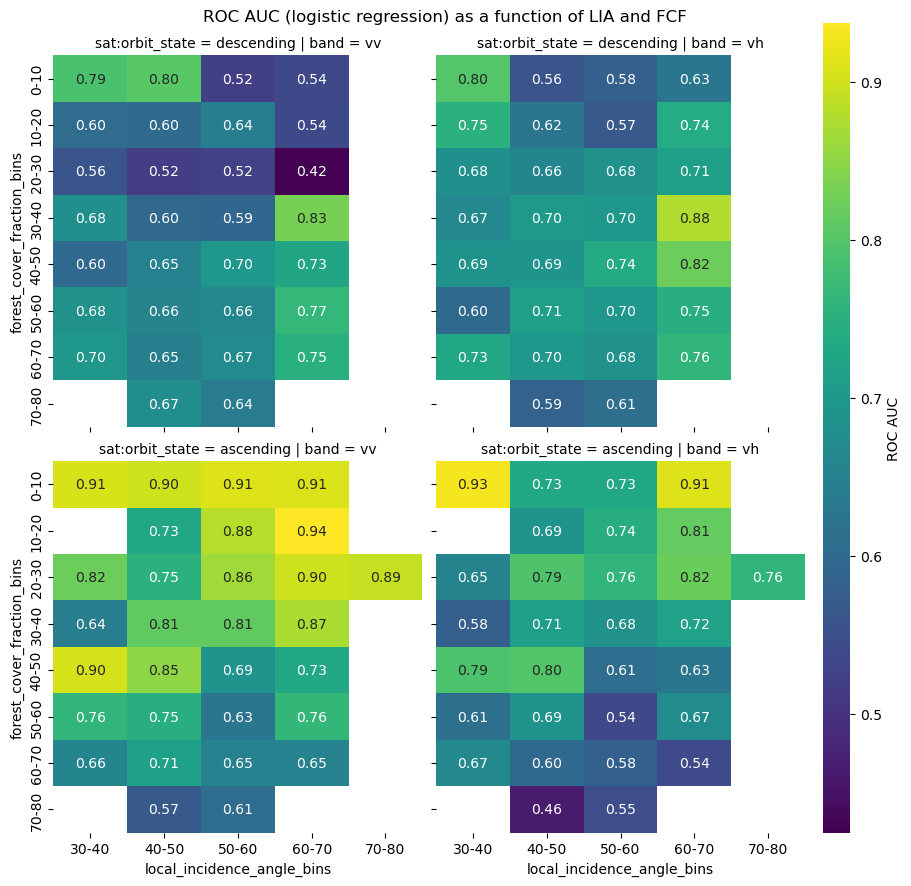

In [121]:
df = roc_auc_logistic
df_vmin = df['val'].min()
df_vmax = df['val'].max()

g = sns.FacetGrid(df, row="sat:orbit_state", col="band", row_order= ['descending','ascending'], col_order=['vv','vh'], legend_out=True, height=4.5)
cbar_ax = g.fig.add_axes([.92, .065, .03, .9])
    
g.map_dataframe(draw_heatmap)
g.fig.suptitle('ROC AUC (logistic regression) as a function of LIA and FCF')

cbar = g.axes.flat[0].collections[0].colorbar
cbar.set_label('ROC AUC')

g.tight_layout()
g.fig.subplots_adjust(right=0.9)

In [123]:
idx = roc_auc_logistic.groupby(['local_incidence_angle_bins','forest_cover_fraction_bins'])['val'].idxmax().dropna() #.reset_index().head(20)

In [124]:
roc_auc_logistic_best = roc_auc_logistic.loc[idx]

In [125]:
roc_auc_logistic_best['band_int'] = roc_auc_logistic_best['band'].apply(lambda x: 0 if x == 'vv' else 1)

Text(0.5, 1.0, 'does vv or vh provide better wet snow seperability?')

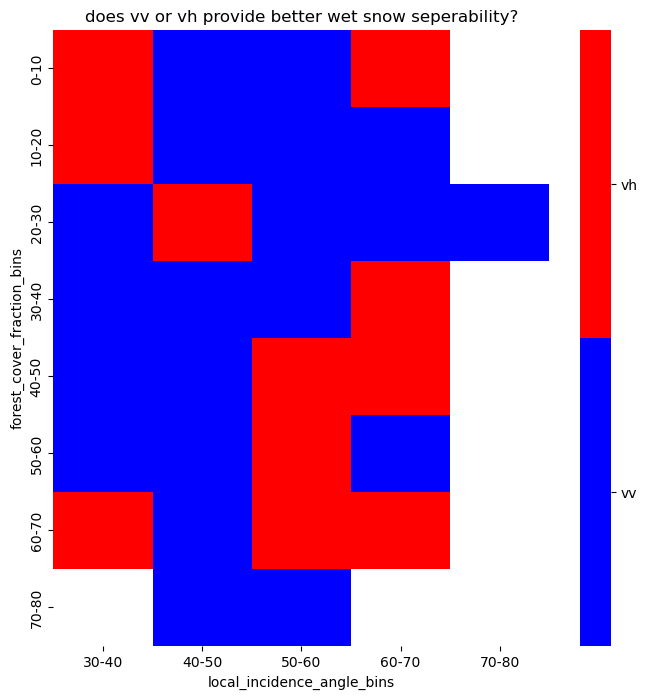

In [126]:
fig, axs = plt.subplots(figsize=(8, 8))


cmap = colors.ListedColormap(['blue', 'red'])

pivot_table = roc_auc_logistic_best.pivot_table(values='band_int', index='forest_cover_fraction_bins', columns='local_incidence_angle_bins')
heatmap = sns.heatmap(pivot_table, cmap=cmap, ax=axs)
colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])

# Set the tick labels to 'vv' and 'vh'
colorbar.set_ticklabels(['vv', 'vh'])
axs.set_title('does vv or vh provide better wet snow seperability?')